In [66]:
library('ggplot2')
library('forecast')
library('tseries')
library("xts")
library("fpp2")
library("dplyr")
library("rugarch")
library("fGarch")
library('zoo')

In [28]:
data = read.csv('../input/goldprice/DatSet.csv')
data$DATE = as.Date(data$DATE, '%d-%m-%Y')

In [29]:
str(data)
summary(data)

'data.frame':	5325 obs. of  5 variables:
 $ DATE     : Date, format: "2001-01-01" "2001-01-02" ...
 $ GOLD     : num  273 273 269 269 268 ...
 $ CRUDE_OIL: num  23 23.4 23.4 24.6 24.8 ...
 $ EX_RATE  : num  1.5 1.5 1.5 1.49 1.5 ...
 $ NASDAQ   : num  2381 2292 2617 2567 2408 ...


      DATE                 GOLD          CRUDE_OIL         EX_RATE     
 Min.   :2001-01-01   Min.   : 256.7   Min.   :  9.12   Min.   :1.149  
 1st Qu.:2006-02-07   1st Qu.: 550.8   1st Qu.: 43.24   1st Qu.:1.414  
 Median :2011-03-16   Median :1181.0   Median : 61.41   Median :1.563  
 Mean   :2011-03-16   Mean   :1025.2   Mean   : 65.18   Mean   :1.572  
 3rd Qu.:2016-04-21   3rd Qu.:1334.2   3rd Qu.: 83.36   3rd Qu.:1.693  
 Max.   :2021-05-28   Max.   :2061.5   Max.   :143.95   Max.   :2.110  
     NASDAQ     
 Min.   : 1114  
 1st Qu.: 2090  
 Median : 2674  
 Mean   : 3983  
 3rd Qu.: 5068  
 Max.   :14139  

In [30]:
data[5325,]

,DATE,GOLD,CRUDE_OIL,EX_RATE,NASDAQ
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
5325,2021-05-28,1892.45,69.36,1.4188,13748.74


In [31]:
nrow(data)

[1] 5325

In [32]:
dat = data.frame(data$GOLD)
ts_price = ts(dat, start = c(2001, 1), frequency = 260.8892617)

In [33]:
str(ts_price)

 Time-Series [1:5325, 1] from 2001 to 2021: 273 273 269 269 268 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr "data.GOLD"


In [34]:
length(ts_price)

[1] 5325

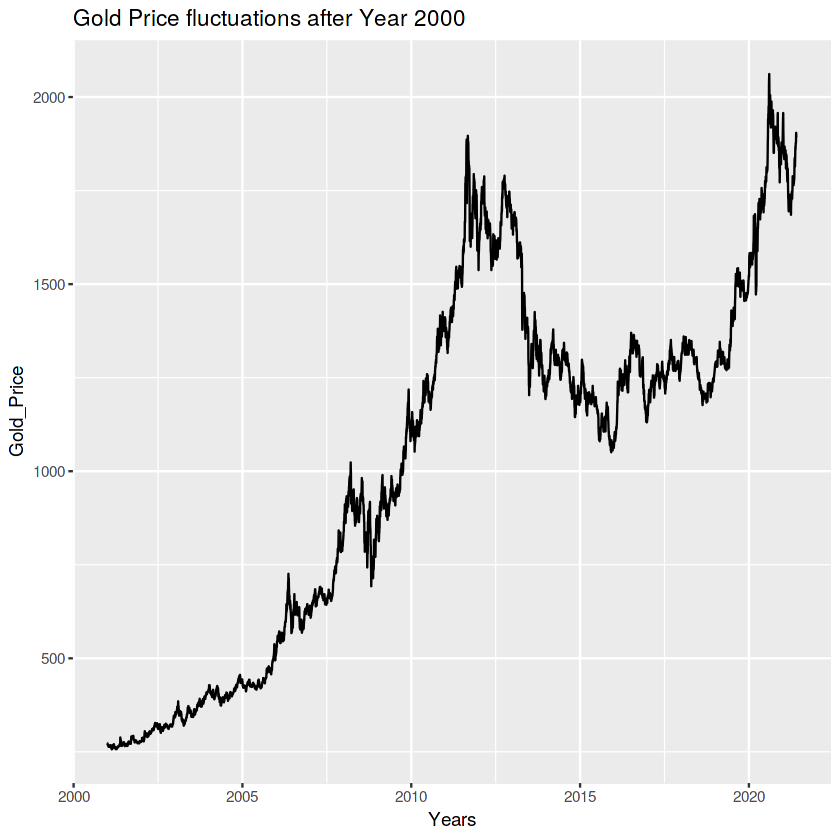

In [35]:
autoplot(ts_price) + ggtitle("Gold Price fluctuations after Year 2000") + ylab("Gold_Price") + xlab('Years')

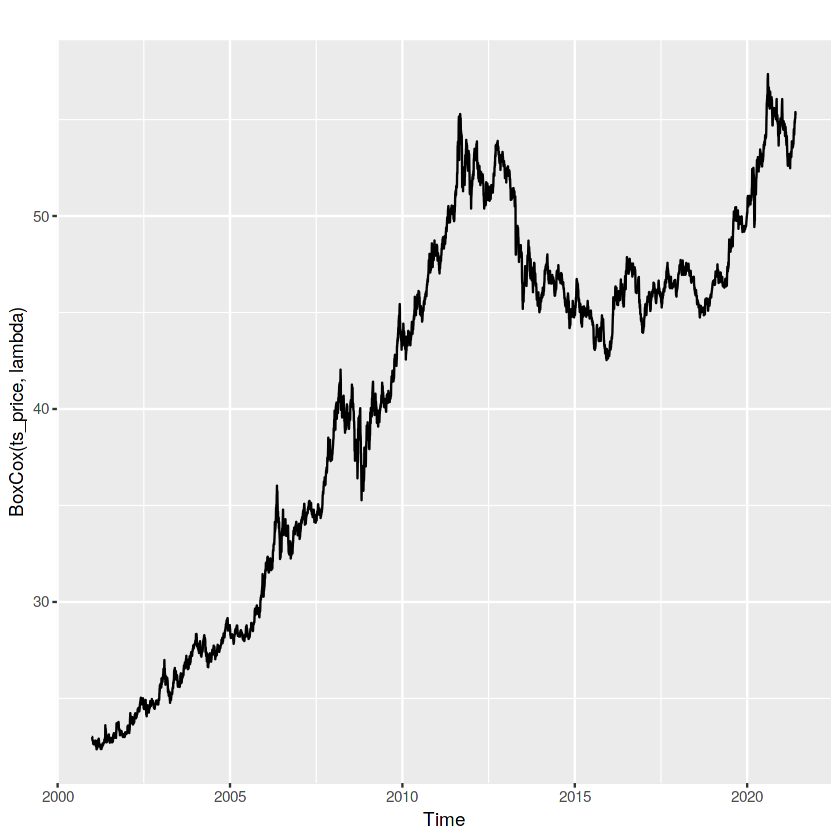

In [36]:
lambda = BoxCox.lambda(ts_price)
autoplot(BoxCox(ts_price, lambda))

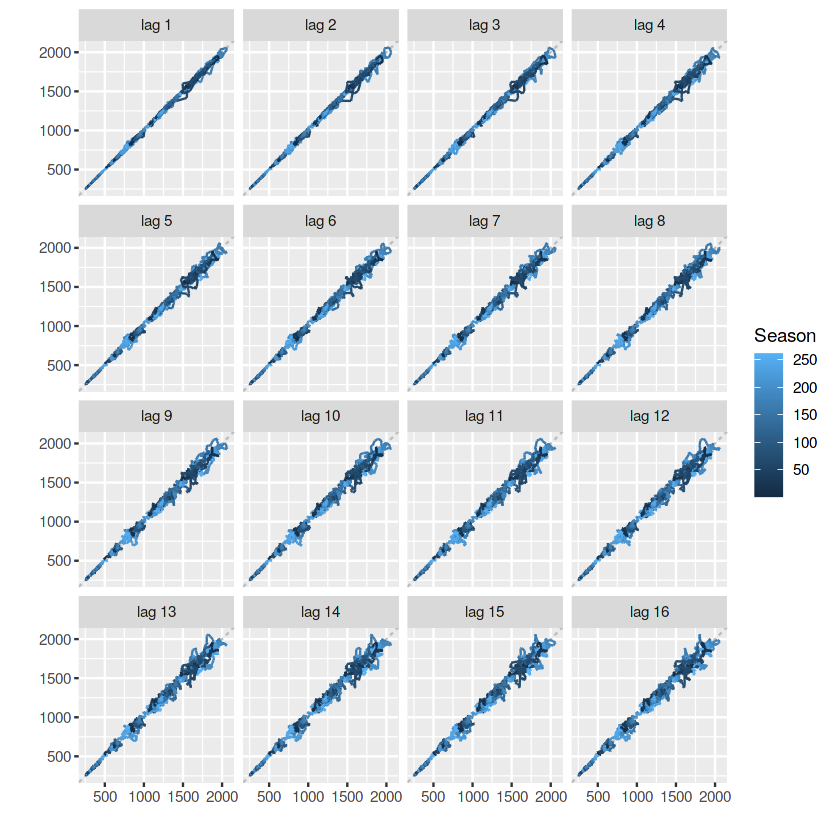

In [37]:
gglagplot(ts_price)   ## From here as the lag increses, correlation decreses a bit.....and same is being
# explainded in ACF Plot

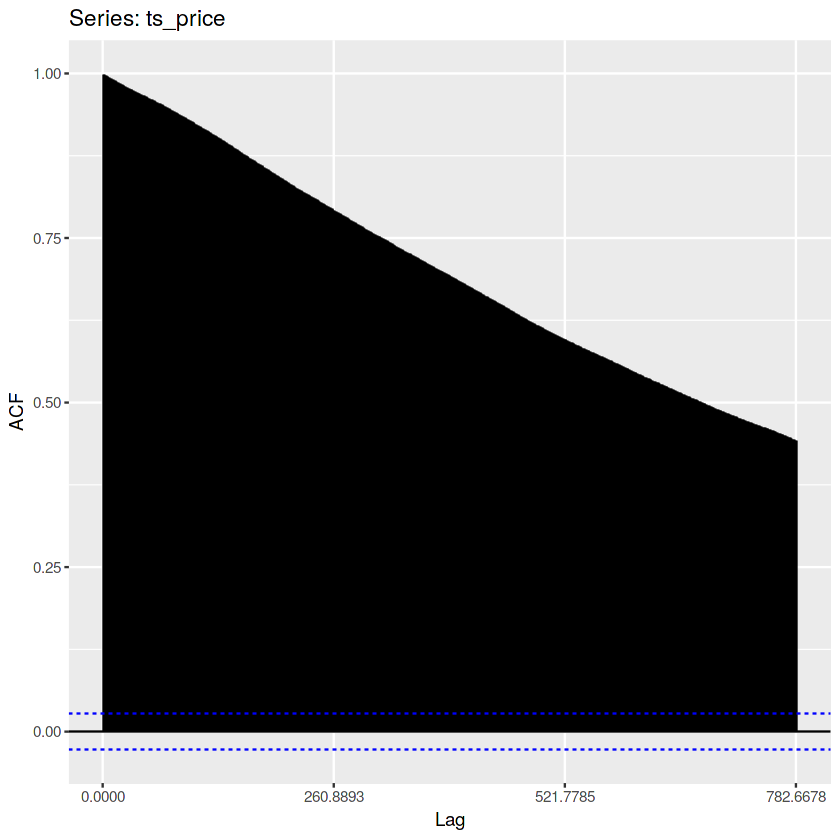

In [38]:
## Check Auto-correlation

ggAcf(ts_price, lag = 783) # Taken for the period of 3 natual time period i.e. 3 year
# No seasonality is observed. We have just the trend.
# ACF decresed slowly as lag increses. ACF for smaller lags tend to be lagre and +ve. So, need diffrencing.

In [39]:
adf.test(ts_price)   # So, Not Stationary as There is clearly a trend.


	Augmented Dickey-Fuller Test

data:  ts_price
Dickey-Fuller = -1.7314, Lag order = 17, p-value = 0.6921
alternative hypothesis: stationary


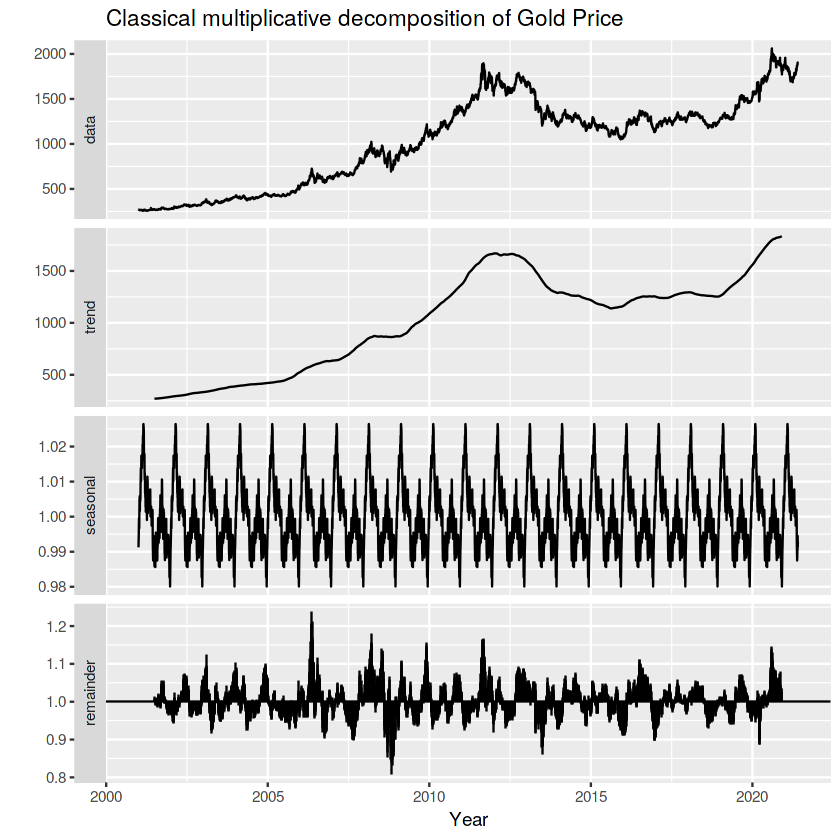

In [40]:
###########################  DECOMPOSTION ###############################
ts_price %>% decompose(type="multiplicative") %>%
  autoplot() + xlab("Year") +
  ggtitle("Classical multiplicative decomposition of Gold Price")

Warning message:
“Removed 100 row(s) containing missing values (geom_path).”


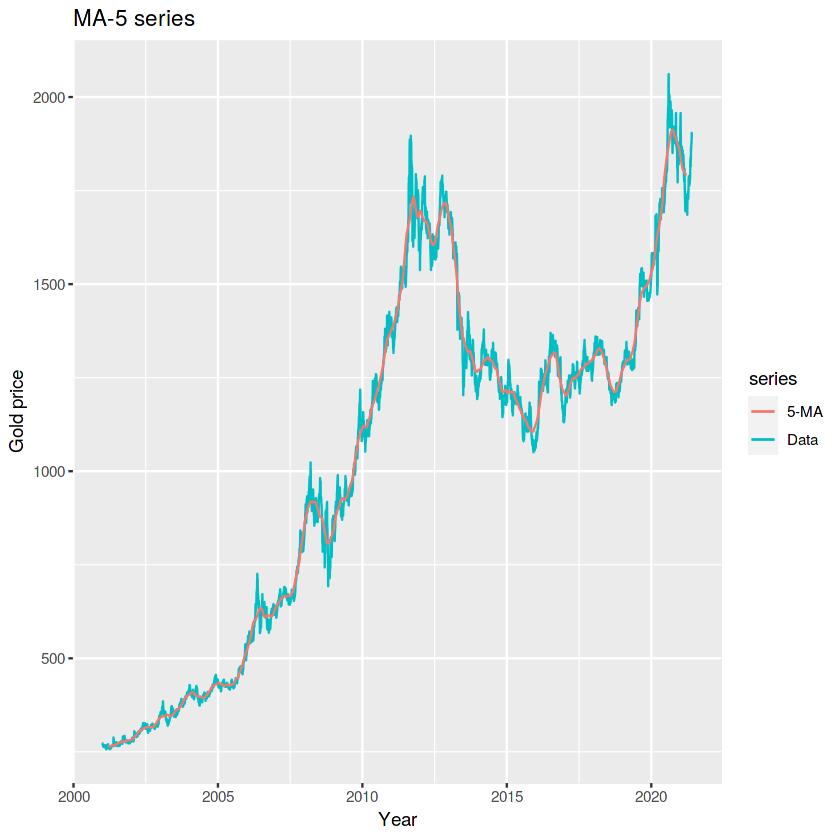

In [41]:
autoplot(ts_price,series = "Data") + 
    autolayer(ma(ts_price,100), series = "5-MA")+ 
      xlab("Year") + ylab("Gold price")+ ggtitle("MA-5 series")    # Since, non-seasonal, so odd order for MA.

In [42]:
###################################   TRAIN - TEST SPLIT ##########################################
train = ts_price[1:5219,]
test=ts_price[5220:5325,]
length(test)

[1] 106

In [65]:
#### 1 Average Method #################
fc = meanf(train, 106)
#autoplot(fc) + xlab('years') + ylab('Gold_Price')


	Ljung-Box test

data:  Residuals from Mean
Q* = 51773, df = 9, p-value < 2.2e-16

Model df: 1.   Total lags used: 10



,ME,RMSE,MAE,MPE,MAPE,MASE
Training set,4.468100e-15,473.9155,416.1526,-40.26049,68.56767,1.000000
Test set,7.894431e+02,791.9749,789.4431,43.81561,43.81561,1.897004


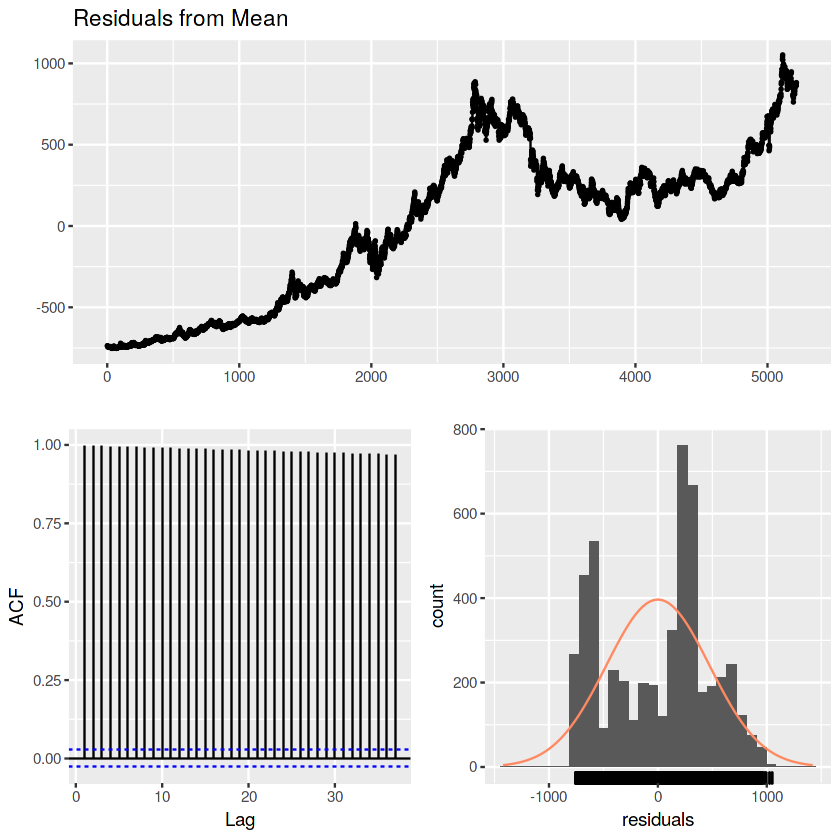

In [44]:
checkresiduals(fc)
accuracy(fc, test)

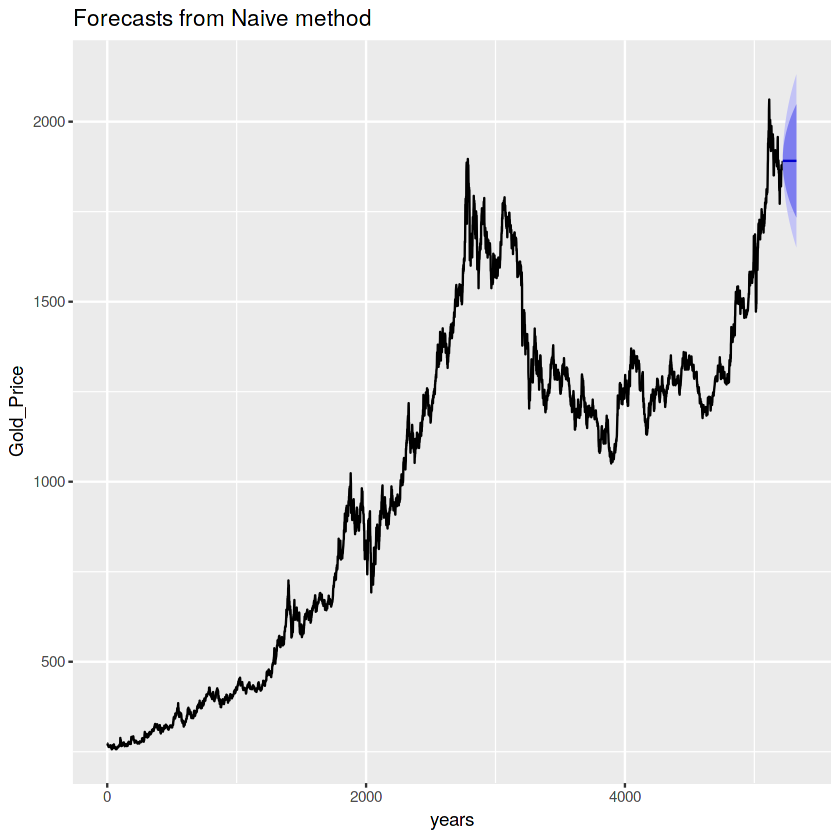


	Ljung-Box test

data:  Residuals from Naive method
Q* = 28.188, df = 10, p-value = 0.001685

Model df: 0.   Total lags used: 10



,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.3101524,11.95428,7.638573,0.03128545,0.7579135,1.00000,-3.371978e-05
Test set,-92.1964623,111.82159,96.342689,-5.25454780,5.4686656,12.61266,NA


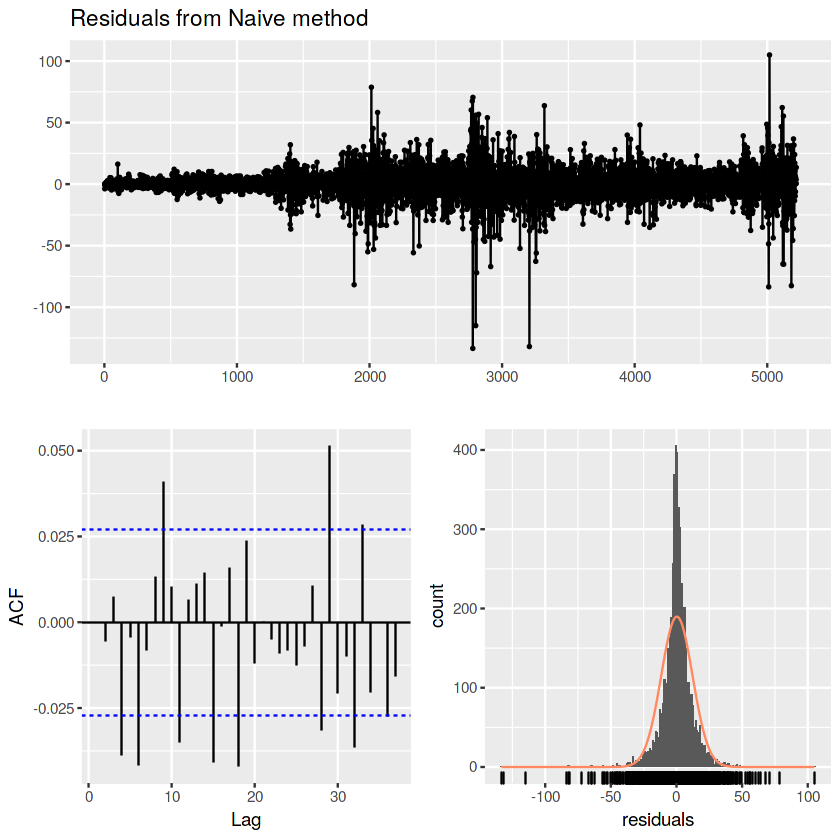

In [45]:
######### 2 Naive Method  #############
fc = naive(train, 106)
autoplot(fc) + xlab('years') + ylab('Gold_Price')
checkresiduals(fc)
accuracy(fc, test)

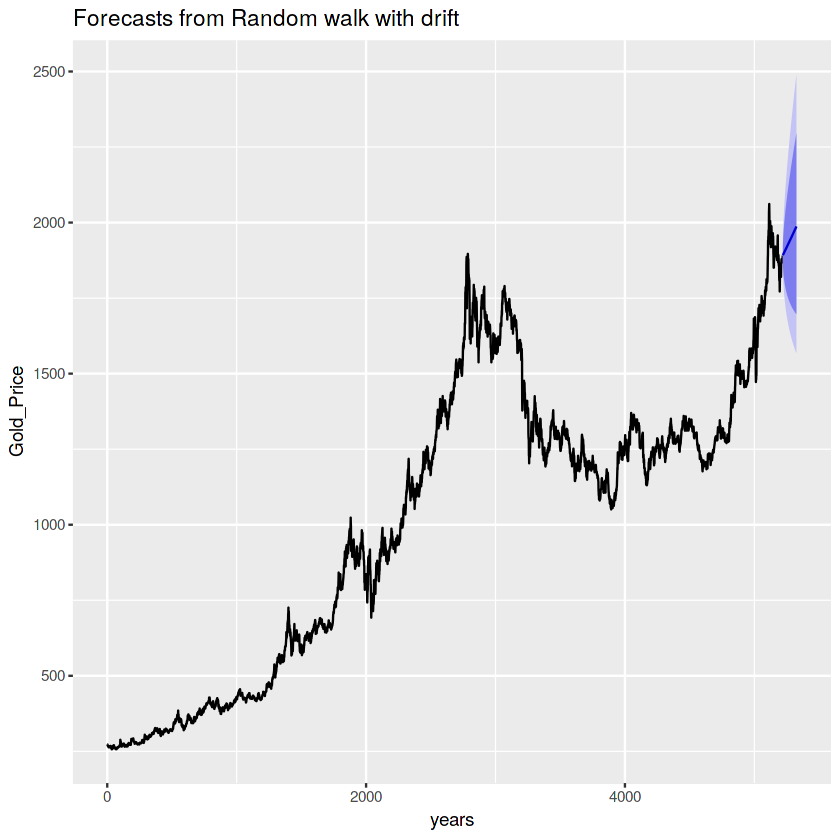


	Ljung-Box test

data:  Residuals from Random walk with drift
Q* = 20.66, df = 9, p-value = 0.01425

Model df: 1.   Total lags used: 10



,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,NaN,NaN,NaN,NaN,NaN,NaN,NA
Test set,-140.1514,158.9602,143.6958,-7.93647,8.119149,18.81186,NA


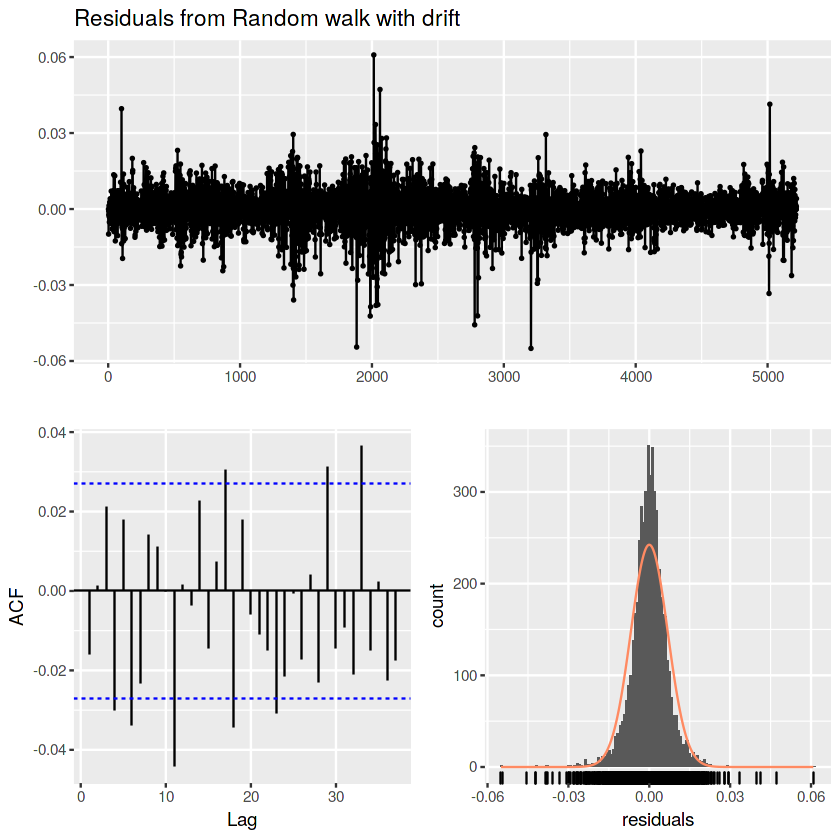

In [46]:
##### 3. Drift Method ####################
lambda = BoxCox.lambda(train)
fc = rwf(train, 106, drift = TRUE, lambda = lambda, biasadj = TRUE)
autoplot(fc) + xlab('years') + ylab('Gold_Price')
checkresiduals(fc)
accuracy(fc, test)

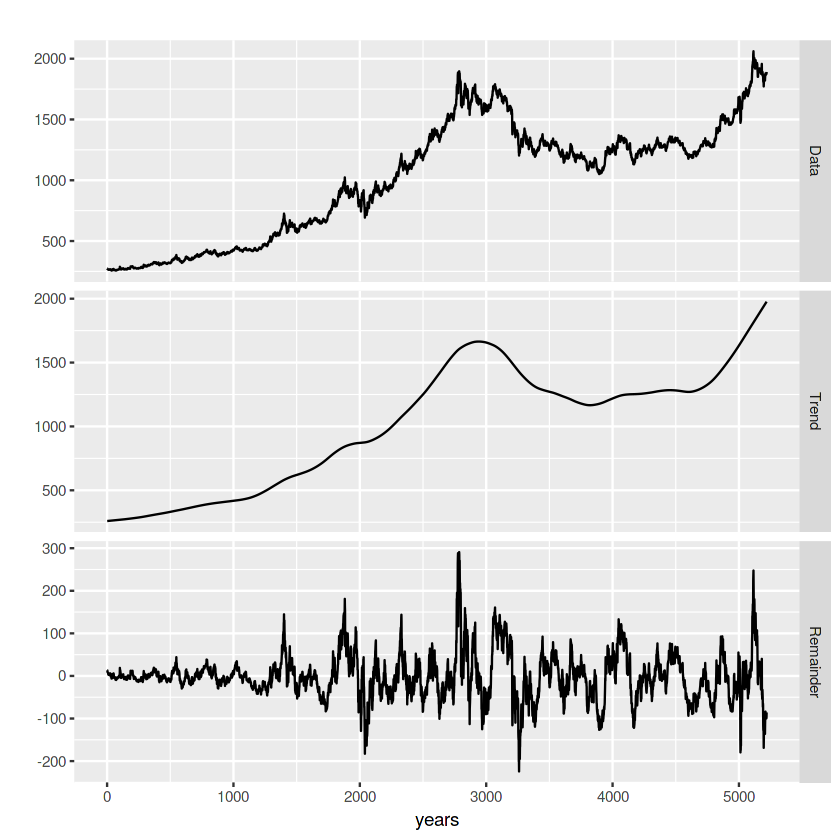

In [47]:
#### 4. TimeSeries Decomposition #########
fc = mstl(train)   # method ----> ETS Algo
autoplot(fc) + xlab('years')     #### So, as we have already done, No seasonal Forecast method. We will continue with this one.

In [48]:
###############   5. Exponential Smoothening ##############
e1 = tsCV(train, ses, h=1)
e2 = tsCV(train, holt, h=1)
e3 = tsCV(train, holt, damped = TRUE, h=1)

In [49]:
## MSE
mean(e1^2, na.rm = TRUE)
mean(e2^2, na.rm = TRUE)
mean(e3^2, na.rm = TRUE)

[1] 143.2237

[1] 143.3244

[1] 143.456

In [50]:
##MAE
mean(abs(e1), na.rm = TRUE)
mean(abs(e2), na.rm = TRUE)
mean(abs(e3), na.rm = TRUE)

[1] 7.642662

[1] 7.637122

[1] 7.650468

Holt's method 

Call:
 holt(y = train, h = 106) 

  Smoothing parameters:
    alpha = 0.9948 
    beta  = 1e-04 

  Initial states:
    l = 275.6544 
    b = 0.3314 

  sigma:  11.9545

     AIC     AICc      BIC 
70578.78 70578.79 70611.58 

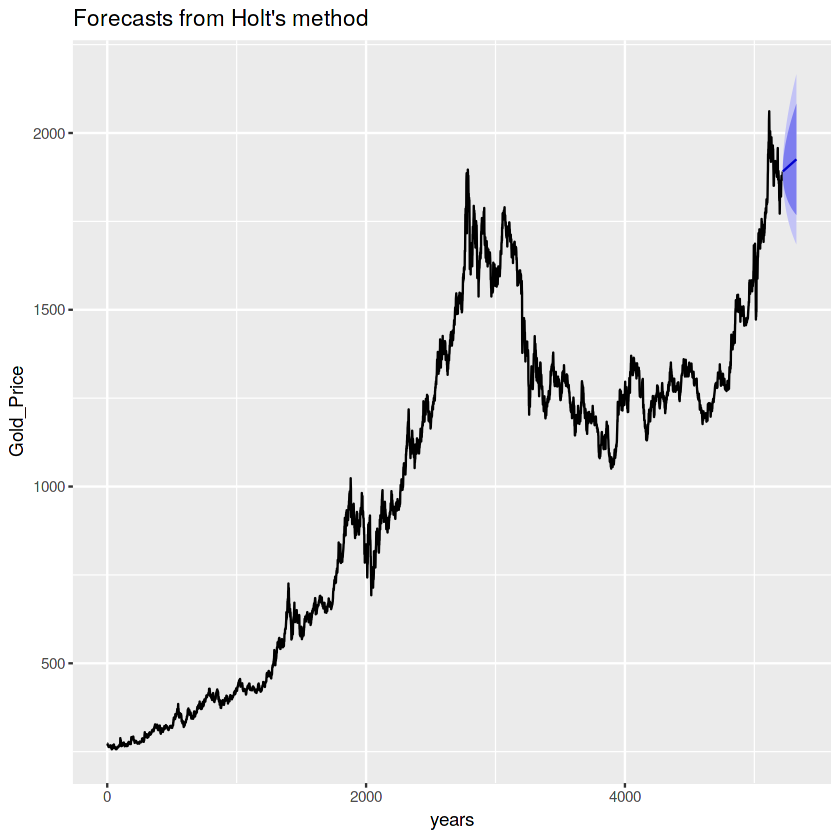


	Ljung-Box test

data:  Residuals from Holt's method
Q* = 28.445, df = 6, p-value = 7.745e-05

Model df: 4.   Total lags used: 10



,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.01056115,11.94994,7.627817,-0.01336546,0.7570306,0.9985919,0.005144153
Test set,-109.56437145,128.15553,113.272034,-6.22596507,6.4170907,14.8289518,NA


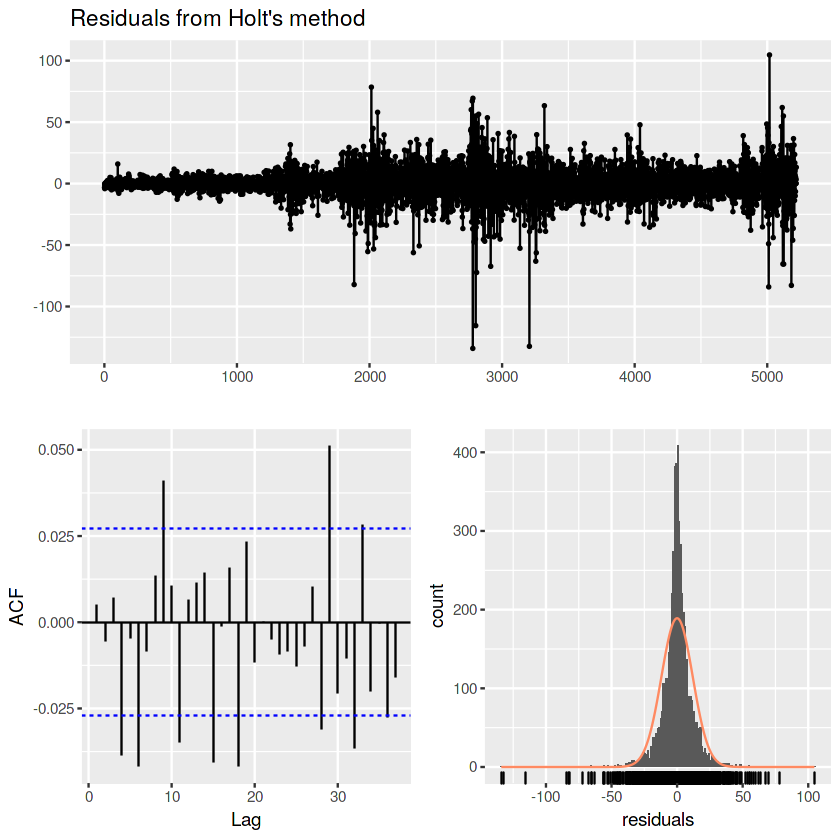

In [51]:
### We will proceed with Trend Method as MAE is min for it.
#Also, if its not the good one then phi will become zero to get ses.
fc = holt(train, h= 106)
fc[['model']]
autoplot(fc) + xlab('years') + ylab('Gold_Price')
checkresiduals(fc)
accuracy(fc, test)

In [52]:
### 6. ETS Model ####################
fit = ets(train)
summary(fit)

ETS(M,A,N) 

Call:
 ets(y = train) 

  Smoothing parameters:
    alpha = 0.9844 
    beta  = 1e-04 

  Initial states:
    l = 277.511 
    b = 0.2425 

  sigma:  0.0108

     AIC     AICc      BIC 
68043.46 68043.47 68076.26 

Training set error measures:
                     ME     RMSE      MAE          MPE      MAPE      MASE
Training set 0.05929965 11.95145 7.628064 -0.002971042 0.7568887 0.9986242
                  ACF1
Training set 0.0155032


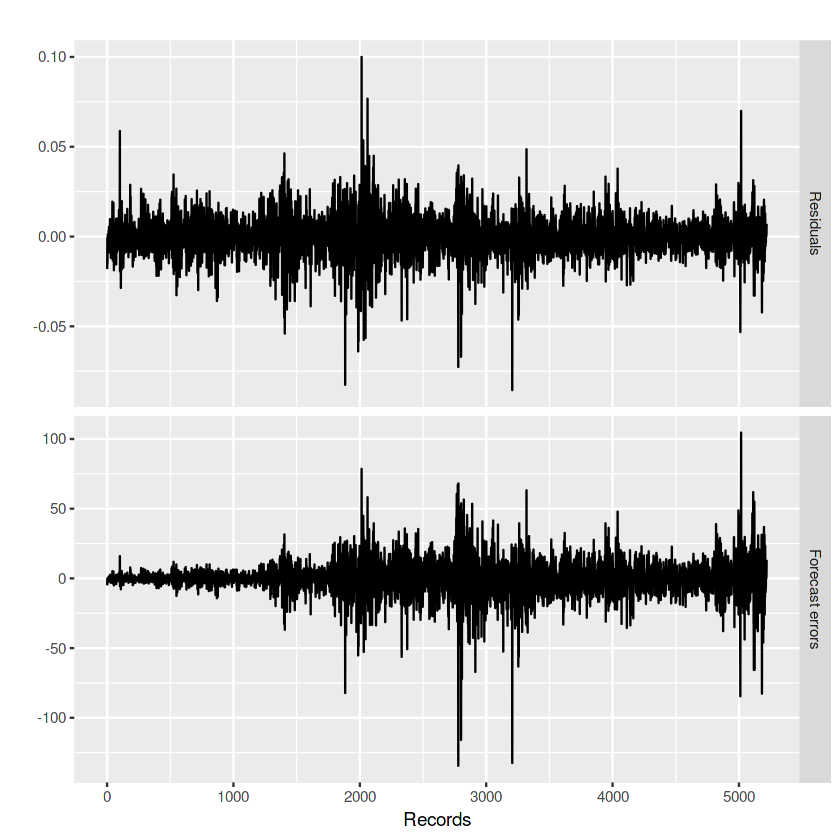

In [53]:
cbind('Residuals' = residuals(fit),    #### NID(0, sigma^2)
      'Forecast errors' = residuals(fit,type='response')) %>%
  autoplot(facet=TRUE) + xlab("Records") + ylab("")

In [54]:
ks.test(residuals(fit)/0.0108, 'pnorm')


	One-sample Kolmogorov-Smirnov test

data:  residuals(fit)/0.0108
D = 0.067149, p-value < 2.2e-16
alternative hypothesis: two-sided


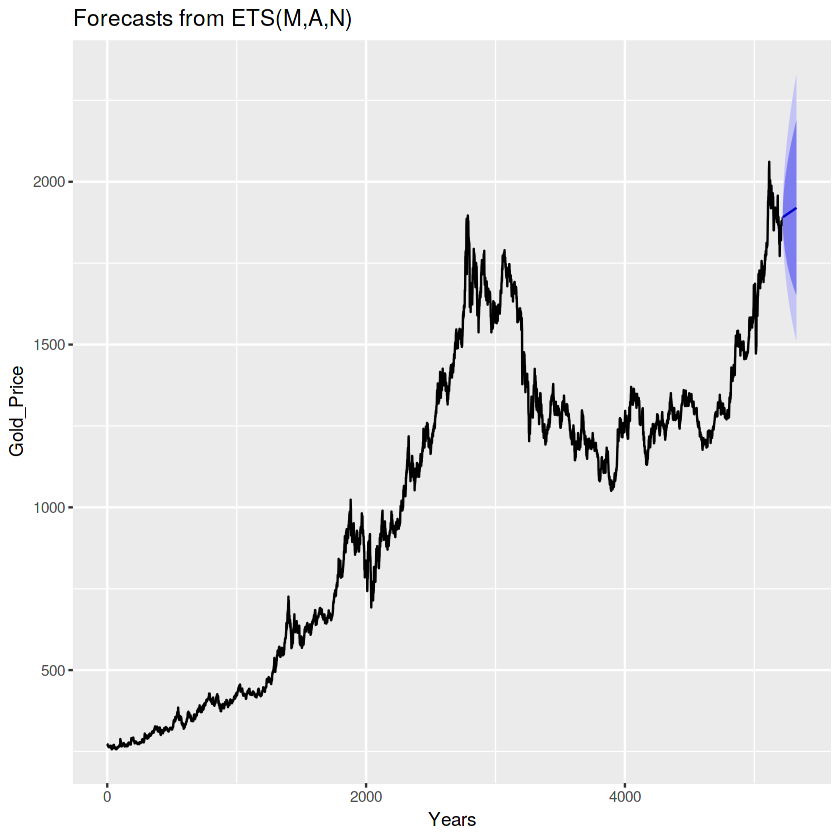


	Ljung-Box test

data:  Residuals from ETS(M,A,N)
Q* = 19.275, df = 6, p-value = 0.003723

Model df: 4.   Total lags used: 10



,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.05929965,11.95145,7.628064,-0.002971042,0.7568887,0.9986242,0.0155032
Test set,-106.61900743,125.32675,110.354666,-6.061266979,6.2538416,14.4470261,NA


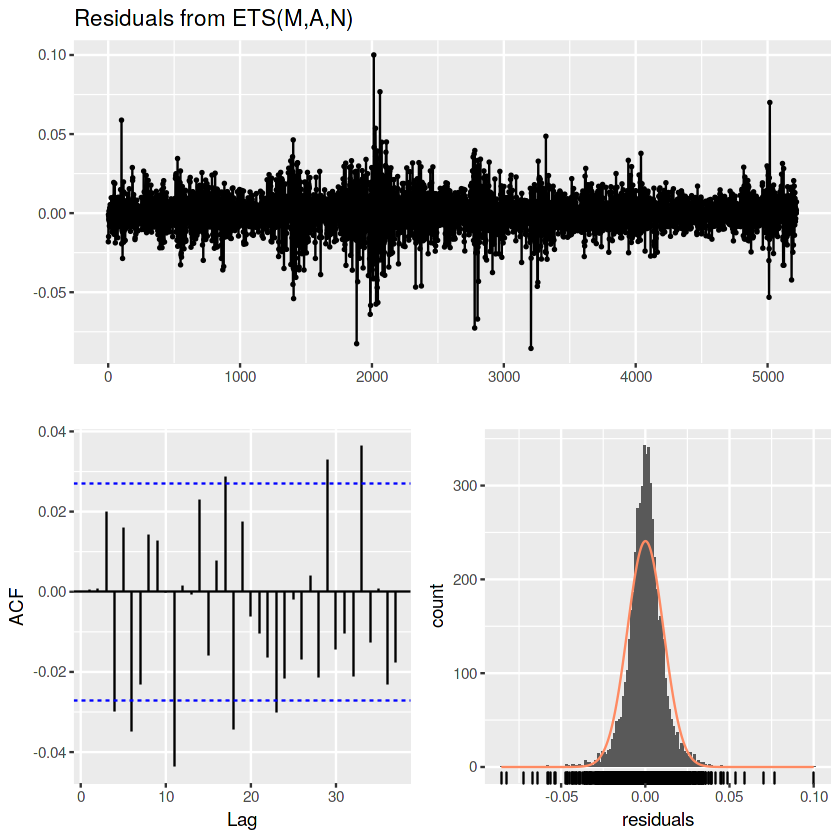

In [55]:
fit %>% forecast(h =106) %>% autoplot() + xlab('Years') + ylab('Gold_Price')
checkresiduals(fit %>% forecast(h =106))
accuracy(fit %>% forecast(h =106), test)

In [56]:
fit = auto.arima(train, stepwise = FALSE, approximation = FALSE, seasonal = TRUE)
summary(fit)

Series: train 
ARIMA(0,1,4) with drift 

Coefficients:
         ma1      ma2     ma3      ma4   drift
      0.0001  -0.0091  0.0072  -0.0383  0.3101
s.e.  0.0139   0.0139  0.0144   0.0137  0.1587

sigma^2 estimated as 142.7:  log likelihood=-20344.43
AIC=40700.85   AICc=40700.87   BIC=40740.21

Training set error measures:
                        ME     RMSE      MAE         MPE     MAPE      MASE
Training set -7.794317e-05 11.93957 7.623139 -0.01225789 0.756551 0.9979795
                     ACF1
Training set 5.982284e-05


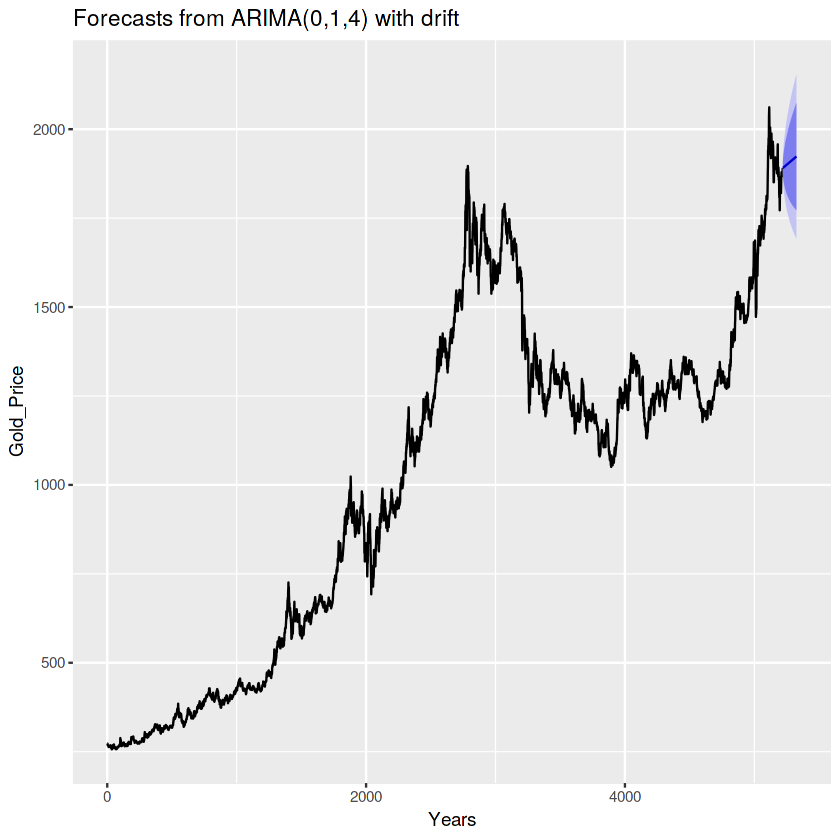

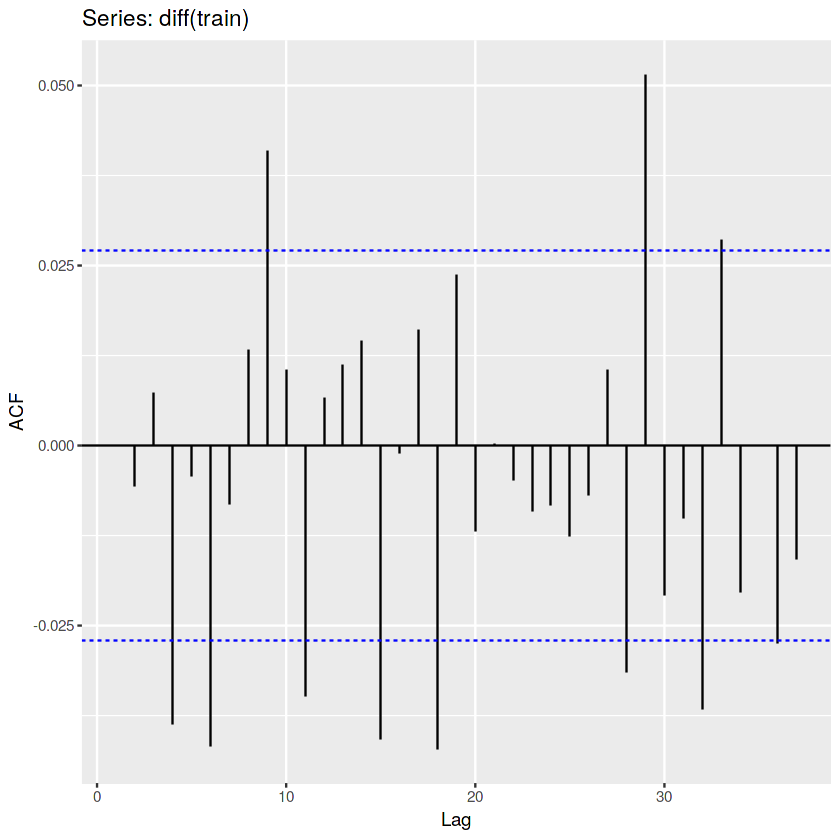

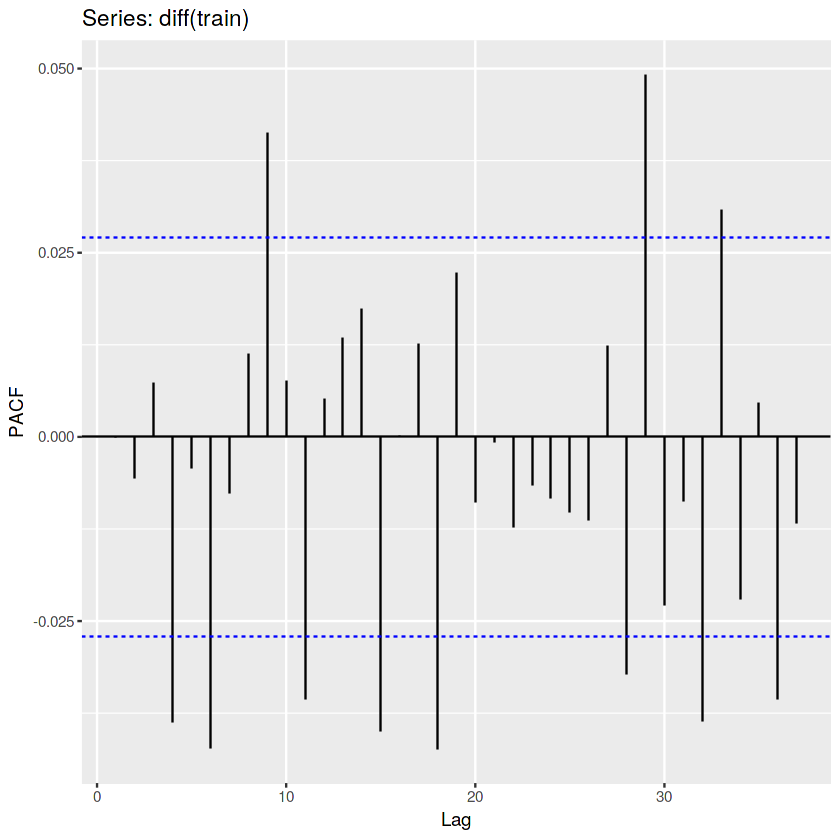


	Ljung-Box test

data:  Residuals from ARIMA(0,1,4) with drift
Q* = 19.893, df = 5, p-value = 0.001309

Model df: 5.   Total lags used: 10



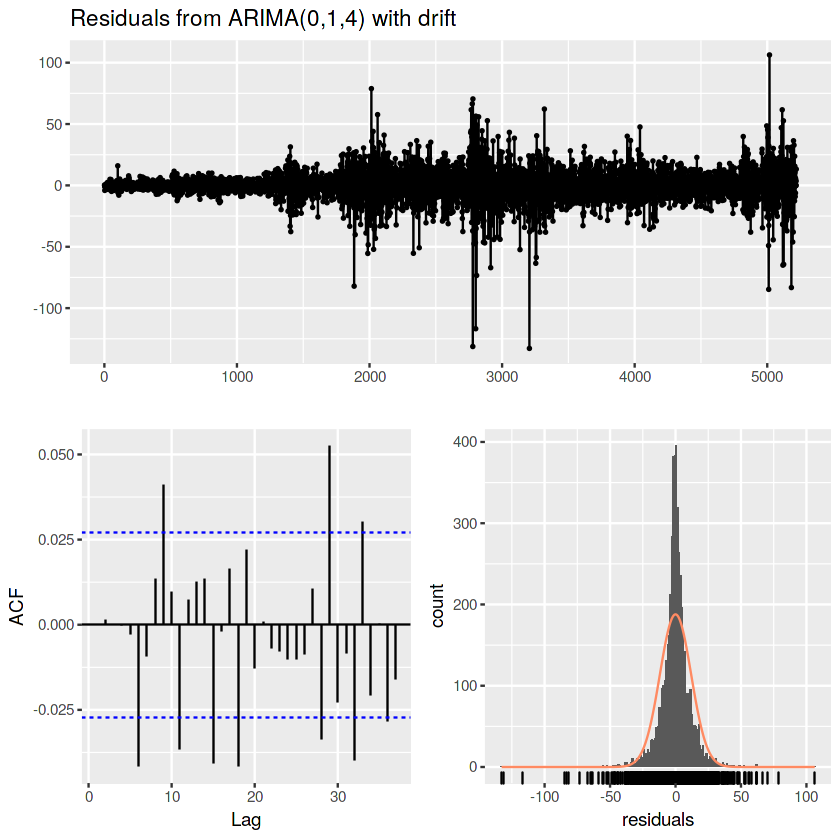

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-7.794317e-05,11.93957,7.623139,-0.01225789,0.756551,0.9979795,5.982284e-05
Test set,-1.081217e+02,126.80879,111.859901,-6.14537723,6.338082,14.6440832,NA


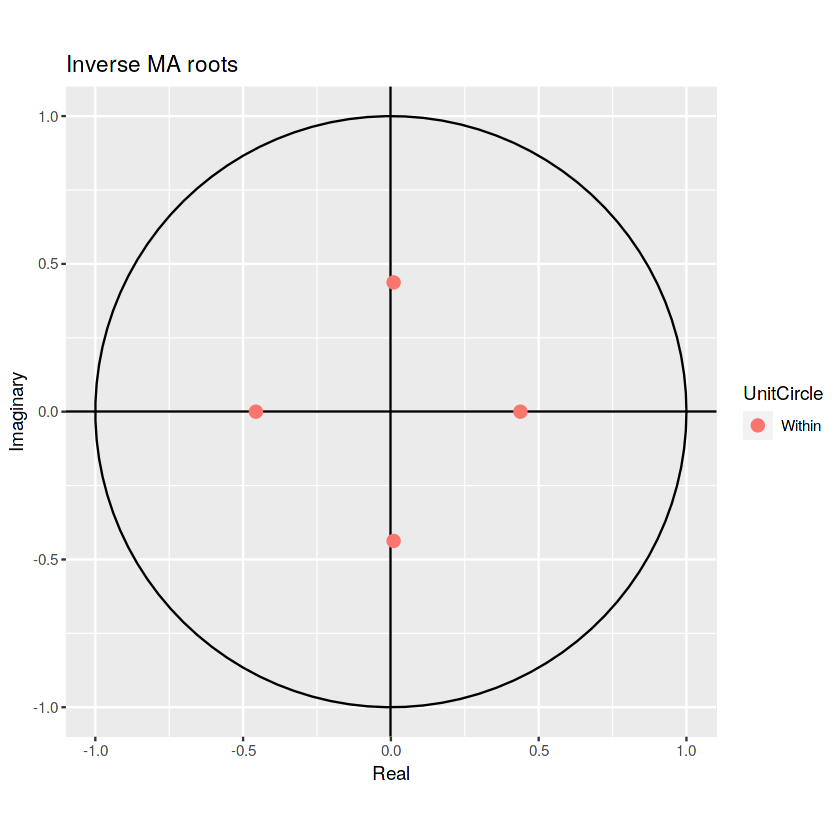

In [57]:
fit %>% forecast(h =106) %>% autoplot() + xlab('Years') + ylab('Gold_Price')
ggAcf(diff(train))   ### ARMIMA(d = 1)
ggPacf(diff(train))
checkresiduals(fit)
autoplot(fit)
accuracy(fit %>% forecast(h =106), test)

In [58]:
######    8. GARCH ###########################
oilfit= ugarchspec(variance.model=list(garchOrder=c(1,1)), mean.model=list(armaOrder=c(0,0)), distribution.model = "std")


garch11.fit=ugarchfit(spec=oilfit, data=train)
garch11.fit   ## AIC And BIC much lesser than Arima's AIC and BIC

garchforecast1 <- ugarchforecast(garch11.fit , n.ahead = 106, data = test)

pred=fitted(garchforecast1)
accuracy(test,pred)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
         Estimate  Std. Error  t value Pr(>|t|)
mu     1.2505e+03    2.001241 624.8639   0.0000
omega  7.6425e+01   14.072591   5.4308   0.0000
alpha1 9.4650e-01    0.052779  17.9332   0.0000
beta1  5.2497e-02    0.050494   1.0397   0.2985
shape  1.0000e+02   14.224023   7.0304   0.0000

Robust Standard Errors:
         Estimate  Std. Error  t value Pr(>|t|)
mu     1.2505e+03   16.918272 73.91435 0.000000
omega  7.6425e+01   23.846800  3.20484 0.001351
alpha1 9.4650e-01    0.063953 14.80002 0.000000
beta1  5.2497e-02    0.069534  0.75498 0.450263
shape  1.0000e+02    1.122824 89.06115 0.000000

LogLikelihood : -35751 

Information Criteria
------------------------------------
       

,ME,RMSE,MAE,MPE,MAPE
Test set,-548.4004,552.0388,548.4004,-43.85438,43.85438


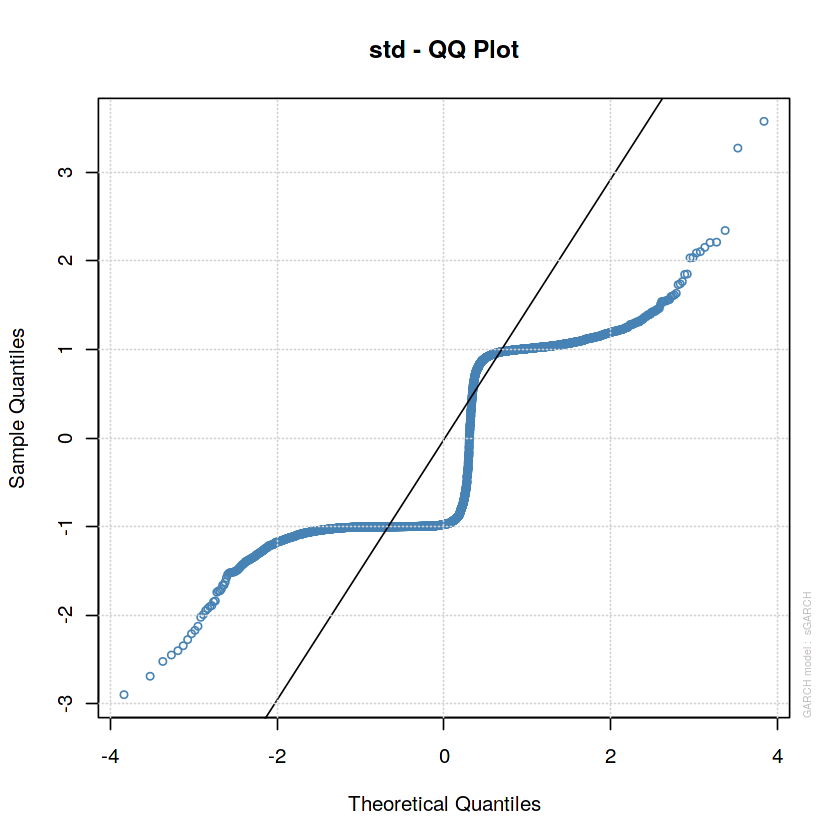

In [59]:
plot(garch11.fit, which=9)  ## Q-Q plot  standardised residual is not normal

In [60]:
oilfit1= ugarchspec(variance.model=list(garchOrder=c(1,1)), mean.model=list(armaOrder=c(1,1)), distribution.model = "std")
garch11.fit1=ugarchfit(spec=oilfit1, data=train)
garch11.fit1  ## AIC and BIC is better than the previous garch model

garchforecast2 <- ugarchforecast(garch11.fit1 , n.ahead = 106, data = test)

pred=fitted(garchforecast2)
accuracy(test,pred) #Both MAPE and RMSE is lesser for this one than the earlier one.


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
         Estimate  Std. Error    t value Pr(>|t|)
mu     272.697159    5.871432 4.6445e+01 0.000000
ar1      1.000000    0.000196 5.1059e+03 0.000000
ma1      0.001340    0.013973 9.5928e-02 0.923578
omega    0.096649    0.036814 2.6253e+00 0.008656
alpha1   0.072564    0.007052 1.0290e+01 0.000000
beta1    0.926436    0.007238 1.2800e+02 0.000000
shape    6.392916    0.462860 1.3812e+01 0.000000

Robust Standard Errors:
         Estimate  Std. Error   t value Pr(>|t|)
mu     272.697159    0.265996 1025.1928 0.000000
ar1      1.000000    0.000268 3732.2243 0.000000
ma1      0.001340    0.013391    0.1001 0.920265
omega    0.096649    0.051979    1.8594 0.062971
alpha1   0.072564    0

,ME,RMSE,MAE,MPE,MAPE
Test set,92.21398,111.836,96.3572,4.876164,5.095252


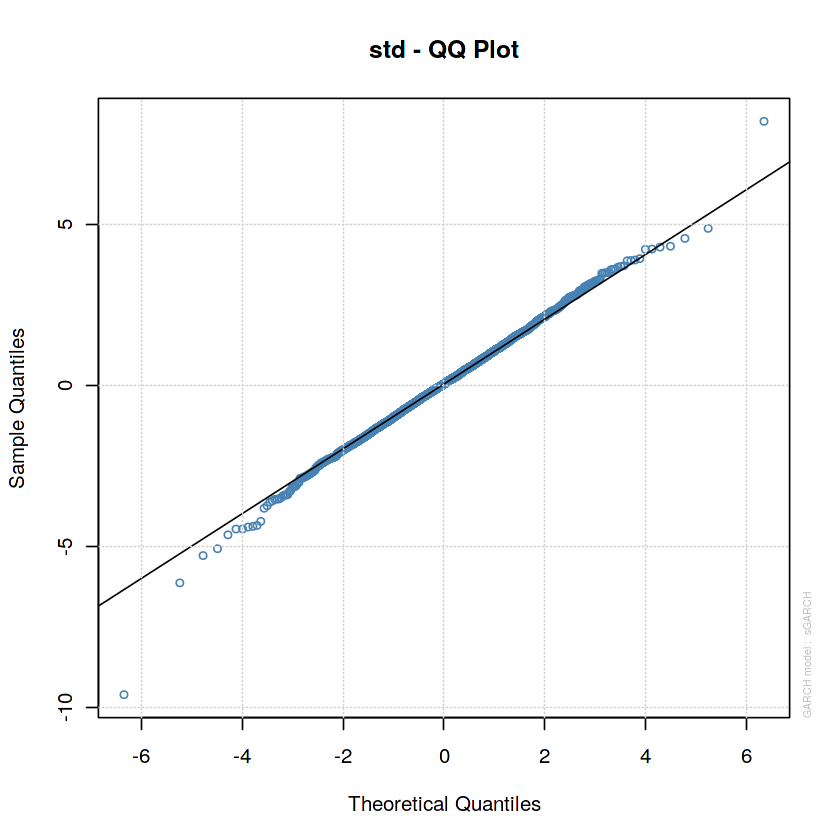

In [61]:
plot(garch11.fit1, which=9)  ## Q-Q plot  standardised residual is not normal

In [62]:
ts<-(ts(data[,c(3:5)],start=c(2001, 1),frequency=260.8892617))
train_reg=ts[1:5219,]
test_reg=ts[5220:5325,]

fit <- auto.arima(train, xreg=train_reg, approximation = FALSE, stepwise = FALSE, seasonal = TRUE)
summary(fit)

Series: train 
Regression with ARIMA(4,1,1) errors 

Coefficients:
         ar1     ar2     ar3      ar4      ma1   drift  CRUDE_OIL   EX_RATE
      0.4379  0.0067  0.0132  -0.0397  -0.4724  0.3008     0.8694  168.7904
s.e.  0.1809  0.0164  0.0152   0.0139   0.1807  0.1476     0.1280   18.6628
      NASDAQ
      0.0035
s.e.  0.0028

sigma^2 estimated as 138.2:  log likelihood=-20259.05
AIC=40538.11   AICc=40538.15   BIC=40603.71

Training set error measures:
                      ME     RMSE      MAE         MPE      MAPE     MASE
Training set 0.001696464 11.74582 7.489522 -0.01458107 0.7504238 0.980487
                      ACF1
Training set -0.0001584017


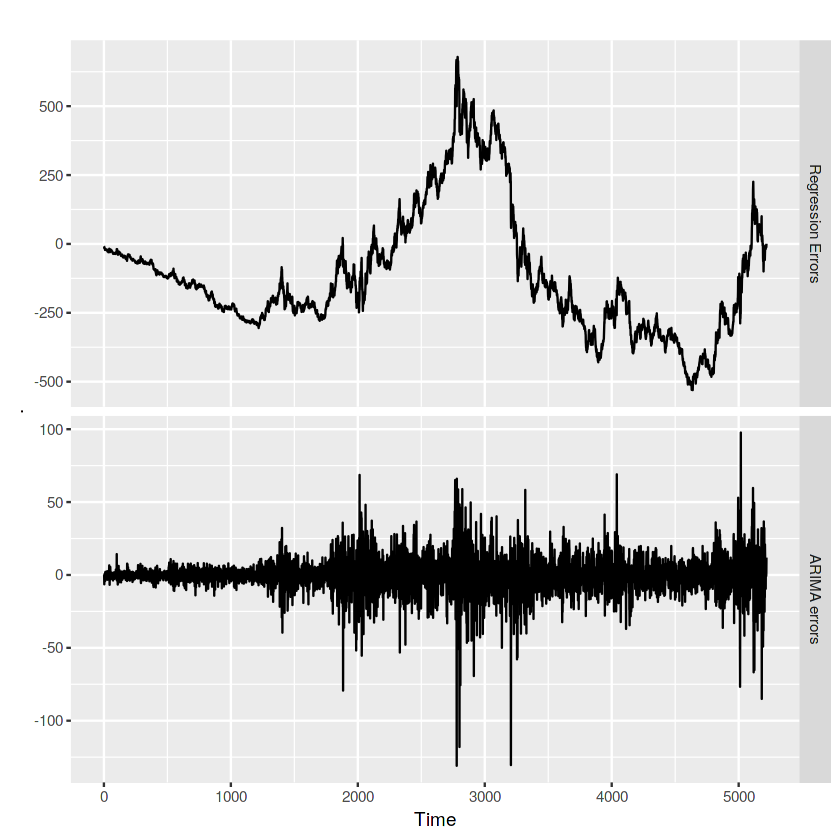

In [63]:
cbind("Regression Errors" = residuals(fit, type="regression"),
      "ARIMA errors" = residuals(fit, type="innovation")) %>%
  autoplot(facets=TRUE)

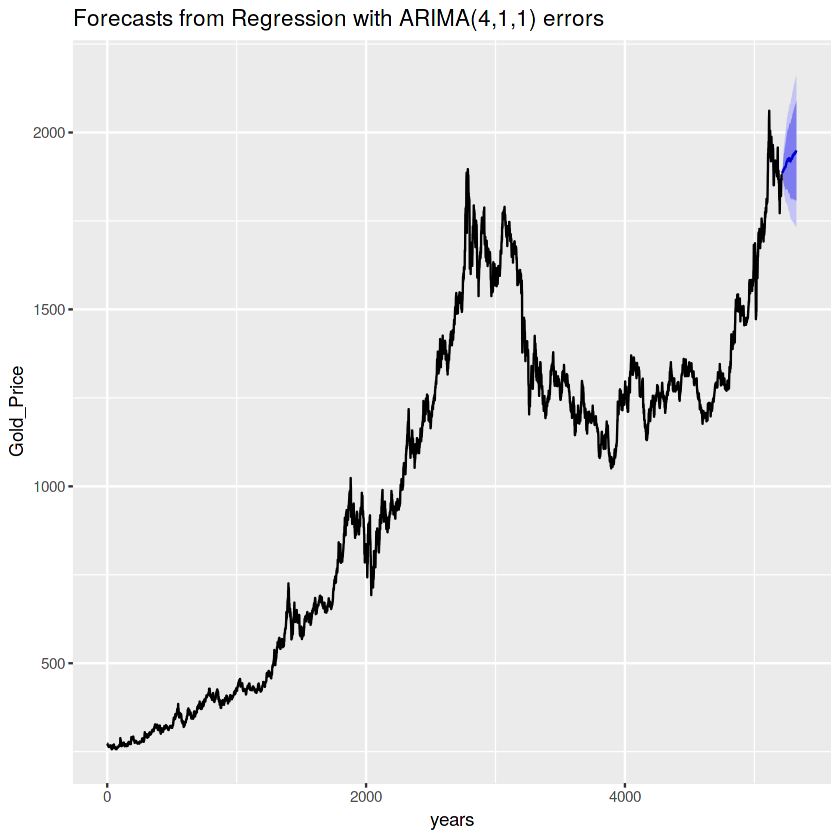


	Ljung-Box test

data:  Residuals from Regression with ARIMA(4,1,1) errors
Q* = 25.492, df = 3, p-value = 1.218e-05

Model df: 9.   Total lags used: 12



,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,1.696464e-03,11.74582,7.489522,-0.01458107,0.7504238,0.980487,-0.0001584017
Test set,-1.228392e+02,141.16904,126.665466,-6.96873177,7.1660214,16.582346,NA


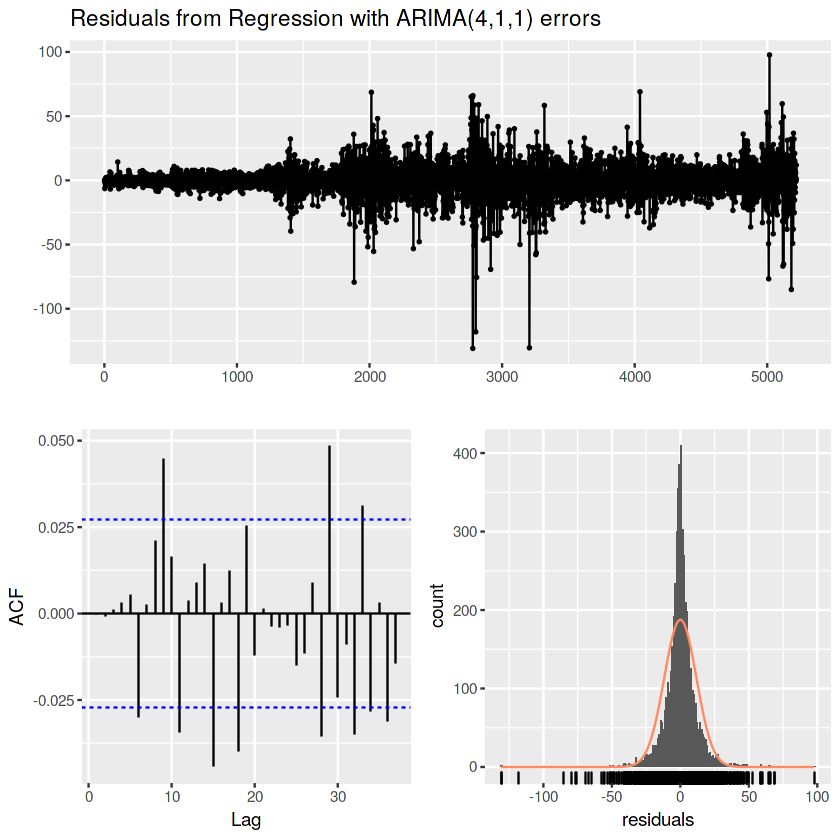

In [64]:
fc = forecast(fit, xreg = test_reg)
autoplot(fc) + xlab('years') + ylab('Gold_Price')
checkresiduals(fc)
accuracy(fc, test)